## Notebook containing code used for manuscript figure 6

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dynamo as dyn
import spateo as st
import os
import seaborn as sns
import sys
from tqdm import tqdm

from scipy.spatial import KDTree

2024-08-15 04:13:38.738409: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 04:13:39.704913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 04:13:41.034169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%config InlineBackend.print_figure_kwargs={'dpi': 300.0}

## Resources used here can be found: https://www.dropbox.com/scl/fo/7wqqasdedsz4vocytbfl1/AO9H5ArH1ArQvwL9hy3CUDg?rlkey=mr77qbw1apxzdm5mlt7wf7f0j&st=qz9yk66j&dl=0
## Database files used here can be found: https://www.dropbox.com/scl/fo/dcd95so9zhkb8lnjkkxep/ANwmkFeb-sgtS89leHQezlU?rlkey=saiul4j5rr1vt6lwjl4hirmwh&st=brpjqw2c&dl=0

### Make sure to change each file path to the relevant local folder

### Load AnnData for ZLI flanking subset and diencephalic ring subset

In [3]:
# Replace with wherever the object is stored locally
path_to_zli = "/home/danielyumengzhu/Single-cell-data/cellbin_mouse_embryo_aligned_E11.5/E11.5_ZLI_final.h5ad"
path_to_dien_ring = "/home/danielyumengzhu/Single-cell-data/cellbin_mouse_embryo_aligned_E11.5/E11.5_diencephalic_ring_final.h5ad"
# Replace with wherever the L:R database is stored locally
lr_db = pd.read_csv("/home/danielyumengzhu/spateo-release/spateo/tools/database/lr_db_mouse.csv", index_col=0)

In [4]:
e115_zli = anndata.read_h5ad(path_to_zli)
e115_zli.uns["__type"] = "UMI"
e115_zli

AnnData object with n_obs × n_vars = 139374 × 21717
    obs: 'area', 'n_genes_by_counts', 'louvain', 'transf_anno', 'ManualAnnotation', 'embryo_id', 'mapped_celltype_with_subtypes', 'mapped_celltype', 'source_subset', 'total_counts', 'n_counts', 'rc_coord', 'slice_id', 'dv_coord'
    uns: '__type', 'celltype_colors'
    obsm: 'X_pca', 'bbox', 'spatial', 'z_correction'
    layers: 'count'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [5]:
e115_dien_ring = anndata.read_h5ad(path_to_dien_ring)
e115_dien_ring.uns["__type"] = "UMI"
e115_dien_ring

AnnData object with n_obs × n_vars = 36249 × 18541
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'n_counts', 'louvain', 'transf_anno', 'ManualAnnotation', 'slice_id', 'embryo_id', 'mapped_celltype', 'heat', 'heat_orth'
    var: 'pass_basic_filter'
    uns: 'PCs', '__type', 'celltype_colors', 'explained_variance_ratio_', 'feature_selection', 'pca_mean', 'pp', 'spatial_neighbors', 'velocyto_SVR'
    obsm: 'X_pca', 'X_spatial_2d_pseudo', 'bbox', 'global_optimization', 'pairwise_align', 'spatial', 'spatial_2d_pseudo', 'spatial_regis', 'z_correction'
    layers: 'X_count', 'count'
    obsp: 'spatial_connectivities', 'spatial_distances'

### Setup for figure 6a ZLI and others plot

In [6]:
e115_zli.obs["zli_and_others"] = e115_zli.obs["mapped_celltype"].copy()
mask = e115_zli.obs["mapped_celltype"] != "Zona limitans intrathalamica"
e115_zli.obs["zli_and_others"] = e115_zli.obs["zli_and_others"].cat.add_categories("Other")
e115_zli.obs.loc[mask, "zli_and_others"] = "Other"

In [7]:
e115_dien_ring.obs["zli_and_others"] = e115_dien_ring.obs["mapped_celltype"].copy()
mask = e115_dien_ring.obs["mapped_celltype"] != "Zona limitans intrathalamica"
e115_dien_ring.obs["zli_and_others"] = e115_dien_ring.obs["zli_and_others"].cat.add_categories("Other")
e115_dien_ring.obs.loc[mask, "zli_and_others"] = "Other"

### Figure 6b

In [ ]:
# Comments: digitization axes in "rc_coord" and "dv_coord" for ZLI flanking region, "heat" and "heat_orth" for diencephalic ring

### Figure 6d ZLI spatial enrichment heatmap

In [8]:
pos_rate = np.sum(e115_zli.X.A!=0,axis=0) / e115_zli.n_obs

In [9]:
e115_zli = e115_zli[:, pos_rate > 0.01].copy()
e115_zli

AnnData object with n_obs × n_vars = 139374 × 7279
    obs: 'area', 'n_genes_by_counts', 'louvain', 'transf_anno', 'ManualAnnotation', 'embryo_id', 'mapped_celltype_with_subtypes', 'mapped_celltype', 'source_subset', 'total_counts', 'n_counts', 'rc_coord', 'slice_id', 'dv_coord', 'zli_and_others'
    uns: '__type', 'celltype_colors'
    obsm: 'X_pca', 'bbox', 'spatial', 'z_correction'
    layers: 'count'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [10]:
e115_zli.uns['pp'] = {}
dyn.pp.normalize_cell_expr_by_size_factors(e115_zli)

/tmp/ipykernel_1439/648888685.py:2: DeprecationWarning:

normalize_cell_expr_by_size_factors is deprecated and will be removed in a future release. Please update your code to use the new replacement function.



|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> Set <adata.X> to normalized data


In [11]:
# Change this to change the save path:
save_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/zli_glm_deg_calibratedRC.csv"

In [ ]:
dyn.tl.glm_degs(e115_zli, fullModelFormulaStr='~rc_coord')
e115_zli.uns['glm_degs'].to_csv(save_path)

In [12]:
e115_zli.uns['glm_degs'] = pd.read_csv(save_path, index_col=0)

In [13]:
df = e115_zli.uns['glm_degs'].copy()
df = df.sort_values('pval',ascending=True)
df['gene'] = df.index.to_list()
df['pval'] = df['pval'].astype(np.float32)

glm_genes = df.loc[df['pval'] < 0.01,:].index.to_list()
len(glm_genes)

3975

In [14]:
exp_mtx = e115_zli.X.todense()
exp_mtx = pd.DataFrame(
    exp_mtx,
    index=e115_zli.obs.index,
    columns=e115_zli.var.index
)

In [15]:
# Shh is expressed along the floor plate as well as the ZLI- we would like only the portion that clusters with the ZLI along the R-C axis
exp_mtx.loc[e115_zli.obs["mapped_celltype"] != "Zona limitans intrathalamica", "Shh"] = 0
exp_mtx.loc[:, "Shh"].sum()

1461.0081114075124

In [16]:
exp_mtx["digital_column"] = e115_zli.obs["rc_coord"].astype(int).to_list()
agg_exp_column = exp_mtx.groupby(["digital_column"]).mean()
agg_exp_column = agg_exp_column.transpose().sort_index(axis=1)

In [17]:
from scipy.ndimage import gaussian_filter1d

agg_exp_column_tmp = agg_exp_column.iloc[:,16:].copy()


agg_exp_column_tmp = agg_exp_column_tmp.apply(
    lambda x: gaussian_filter1d(x, 3).tolist(),
    axis=1,
)
agg_exp_column_tmp = pd.DataFrame(
    agg_exp_column_tmp.to_list(),
    index=agg_exp_column.index,
    columns=agg_exp_column.columns[16:],
)

agg_exp_column_tmp = agg_exp_column_tmp.loc[glm_genes]
agg_exp_column_tmp = agg_exp_column_tmp.loc[agg_exp_column_tmp.idxmax(axis=1).sort_values().index]

#### Cluster expression along R-C

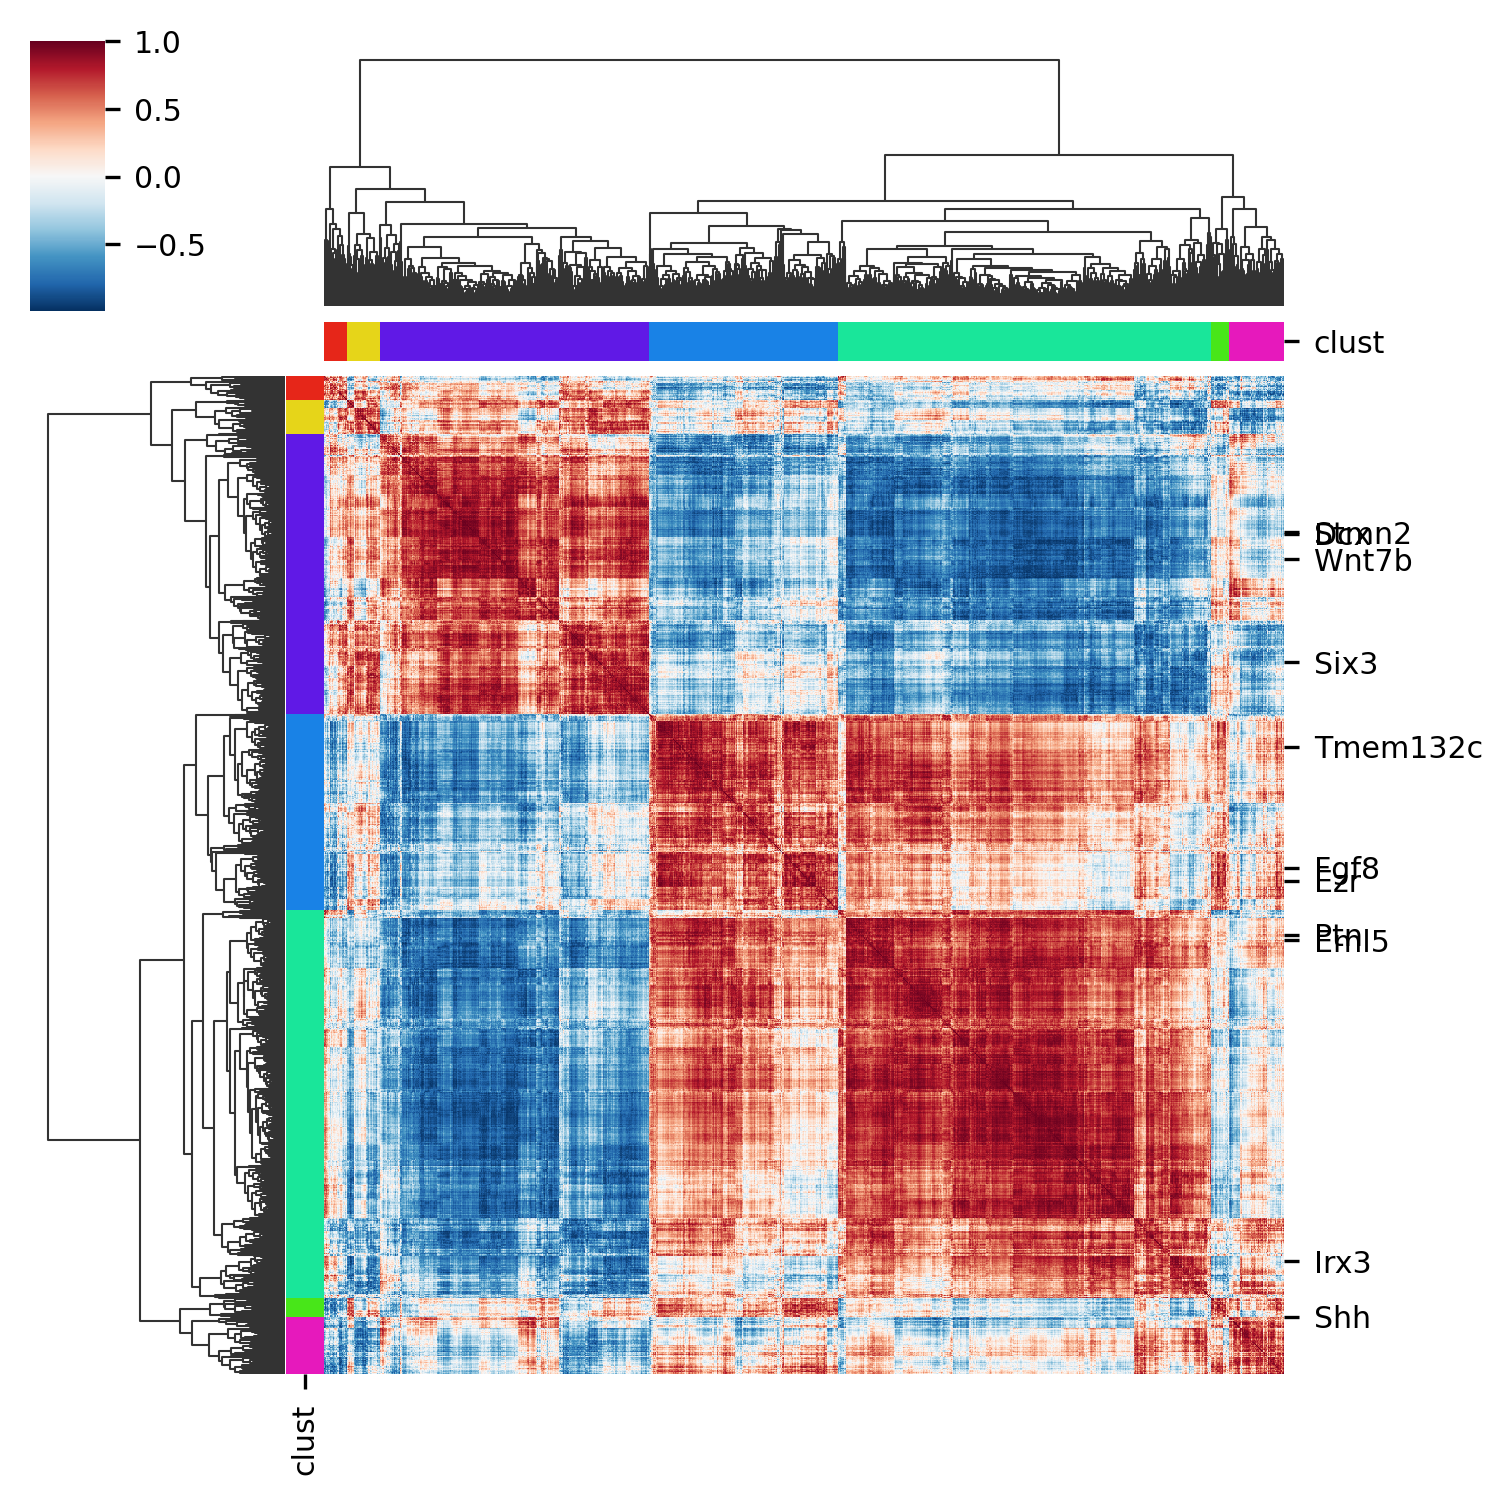

In [18]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial import distance

agg_exp_column_tmp_stand = ((agg_exp_column_tmp.T - agg_exp_column_tmp.T.min()) / (agg_exp_column_tmp.T.max() - agg_exp_column_tmp.T.min())).T
agg_exp_column_tmp_stand

correlations = agg_exp_column_tmp_stand.T.corr()
correlations_array = np.asarray(agg_exp_column_tmp_stand.T.corr())

row_linkage = linkage(
    distance.pdist(correlations_array), method='average')

correlations['clust'] = fcluster(row_linkage, criterion="maxclust",t=7)

pal = sns.hls_palette(len(set(correlations['clust'])), l=0.5, s=0.8)
np.random.shuffle(pal)
lut = dict(zip(set(correlations['clust']), pal))
row_colors = pd.DataFrame(correlations['clust'])['clust'].map(lut)


g = sns.clustermap(correlations.iloc[:,:-1],
                   row_linkage=row_linkage, col_linkage=row_linkage,
                   row_colors=row_colors, col_colors=row_colors,
                   method="average",figsize=(5, 5),
                   cmap="RdBu_r",
                   rasterized=True,xticklabels=False,
                  )


reordered_labels = agg_exp_column_tmp.index[g.dendrogram_col.reordered_ind].tolist()
# Change these to any genes based on preference
use_labels = ["Shh", "Ptn","Tmem132c", "Fgf8","Ezr",
              "Irx3", "Dcx","Eml5","Stmn2",
              "Six3", "Wnt7b",
             ]
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)
plt.show(g)

### Figure 6e- polarity plots (for gene expression)

In [19]:
e115_zli = anndata.read_h5ad(path_to_zli)
e115_zli.uns["__type"] = "UMI"
e115_zli

AnnData object with n_obs × n_vars = 139374 × 21717
    obs: 'area', 'n_genes_by_counts', 'louvain', 'transf_anno', 'ManualAnnotation', 'embryo_id', 'mapped_celltype_with_subtypes', 'mapped_celltype', 'source_subset', 'total_counts', 'n_counts', 'rc_coord', 'slice_id', 'dv_coord'
    uns: '__type', 'celltype_colors'
    obsm: 'X_pca', 'bbox', 'spatial', 'z_correction'
    layers: 'count'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [20]:
def polarity(
    test_df,
    column_dict: dict,
    region_key: str,
    palette: list,
    mode: str = "density",
    itv_rpt: int = 1,
    width: int = 5,
    height: int = 3.5,
    region_lower_bound=None,  # Optional parameters for region bounds
    region_upper_bound=None,
):
    """Visualize data variation along regions using columns from a DataFrame.

    Args:
        test_df (DataFrame): Data to be visualized.
        column_dict (dict): Specifies columns to be visualized, potentially grouped by annotations.
        region_key (str): Column name in test_df indicating regions.
        mode (str, optional): Visualization mode ('density' or 'exp'). Defaults to "density".
        region_lower_bound (int, optional): Lower bound of the region to highlight.
        region_upper_bound (int, optional): Upper bound of the region to highlight.
    """
    import scipy.stats as stat
    digi_region = np.array([])
    column_list = np.array([])
    column_mean = np.array([])
    column_mean_low = np.array([])
    column_mean_high = np.array([])

    if mode == "exp":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    column_mean_tmp = df_tmp[column].to_numpy()
                    digi_region = np.append(digi_region, np.repeat(i, len(df_tmp)))
                    column_list = np.append(column_list, np.repeat(column + " " + anno, len(df_tmp)))
                    column_mean = np.append(column_mean, column_mean_tmp)
        df_plt = pd.DataFrame({region_key: digi_region, "Column": column_list, "Mean value": column_mean})
        ax = sns.relplot(data=df_plt, x=region_key, y="Mean value", hue="Column")
    elif mode == "density":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    digi_region = np.append(digi_region, i)
                    column_list = np.append(column_list, column + " " + anno)
                    column_mean = np.append(column_mean, np.mean(df_tmp[column]))
                    data = df_tmp[column].to_numpy()
                    data = np.repeat(data, itv_rpt)
                    l, h = stat.t.interval(alpha=0.7, df=len(data)-1, loc=np.mean(data), scale=stat.sem(data))
                    if np.isnan(l):
                        l = np.mean(data)
                    if np.isnan(h):
                        h = np.mean(data)
                    column_mean_low = np.append(column_mean_low, max(0, l))
                    column_mean_high = np.append(column_mean_high, h)
        column_mean_low = column_mean_low + 1e-10
        column_mean_high = column_mean_high + 1e-10
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean})
        df_plt['Avg. effect'] = df_plt['Avg. effect'].clip(lower=0)
        plt.figure()
        p1 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p1.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_low})
        plt.figure()
        p2 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p2.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_high})
        plt.figure()
        p3 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p3.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        fig, ax = plt.subplots()
        fig.set_size_inches((width, height))
        uq_cl = np.unique(column_list)
        for k in range(len(uq_cl)):
            ax.plot(p1.get_children()[k].get_data()[0], p1.get_children()[k].get_data()[1], '-', color=palette[len(palette)-k-1])
            ax.fill_between(
                p1.get_children()[k].get_data()[0],
                p2.get_children()[k].get_data()[1]*np.sum(column_mean_low[column_list==uq_cl[-(k+1)]]) / np.sum(column_mean[column_list==uq_cl[-(k+1)]]),
                p3.get_children()[k].get_data()[1]*np.sum(column_mean_high[column_list==uq_cl[-(k+1)]])/ np.sum(column_mean[column_list==uq_cl[-(k+1)]]), color=palette[len(palette)-k-1], alpha=0.2)

        if region_lower_bound is not None and region_upper_bound is not None:
            plot_width = region_upper_bound - region_lower_bound
            region_box = mpl.patches.Rectangle(
                (region_lower_bound, ax.get_ylim()[0]),
                plot_width,
                ax.get_ylim()[1] - ax.get_ylim()[0],
                linewidth=1,
                edgecolor="#1CE6FF",
                facecolor="#1CE6FF",
                alpha=0.1,
            )
            ax.add_patch(region_box)
    return ax

In [21]:
# Wnt genes
genes = ["Wnt7b", "Wnt8b", "Wnt9a", "Wnt3a", "Wnt5a", "Wnt3"]

In [22]:
temp_df = pd.DataFrame(0, index=e115_zli.obs_names, columns=genes)
for gene in genes:
    temp_df[gene] = e115_zli[:, gene].X.toarray()

In [23]:
ax = e115_zli.obsm["z_correction"][:, 0].astype(int)
ax = (ax - ax.min()) / (ax.max() - ax.min()) * 100
temp_df["rc_coord"] = ax

In [ ]:
# Guide:
# Wnt7b = blue
# Wnt8b = orange
# Wnt9a = green
# Wnt3a = red
# Wnt5a = purple
# Wnt3 = brown

gene_dict = {
    "1": ["Wnt7b"],
    "2": ["Wnt8b"],
    "3": ["Wnt9a"],
    "4": ["Wnt3a"],
    "5": ["Wnt5a"],
    "6": ["Wnt3"],
}

In [25]:
import matplotlib as mpl
palette = [mpl.colors.to_hex(i) for i in sns.color_palette("tab10", n_colors=len(gene_dict))]
palette

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

/tmp/ipykernel_1439/3498202625.py:51: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning:

invalid value encountered in multiply



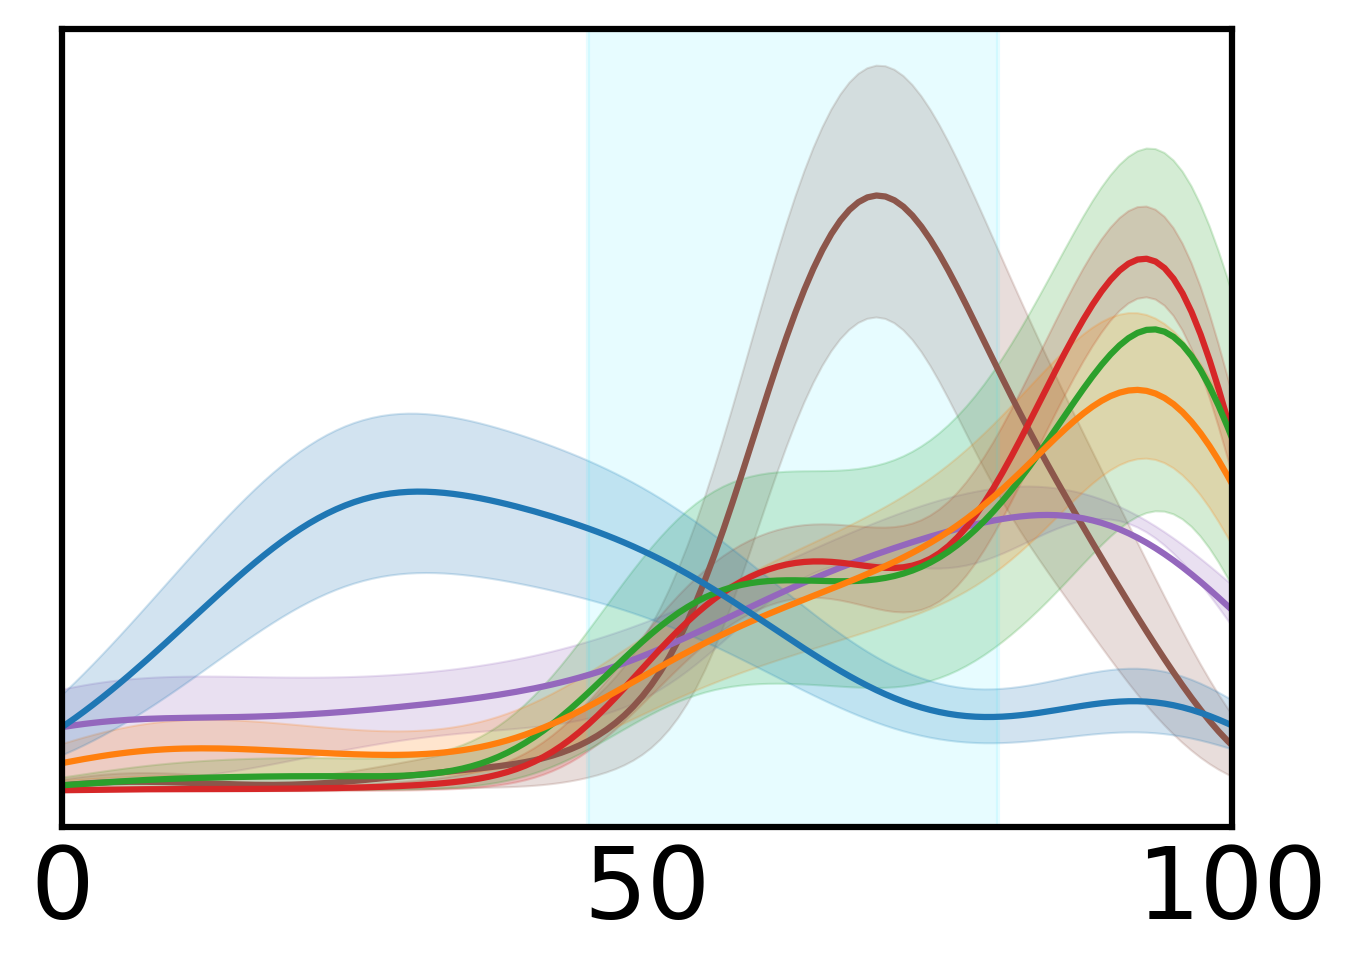

In [26]:
ax = polarity(temp_df, gene_dict, region_key="rc_coord",
              palette=palette,
              itv_rpt=1,
              region_lower_bound=45,
              region_upper_bound=80,
             )

ax.tick_params(direction="out")
ax.set_yticks([])
# Remove the tick marks but keep the labels for the x-axis
ax.tick_params(axis='x', length=0, labelsize=24)

plt.xlim([0, 100])
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

In [ ]:
# Replace path with appropriate local path for you
plt.savefig("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/KDE_expression_Wnts.pdf", bbox_inches = "tight", transparent=True, width=2, height=1)

In [27]:
# Lhx genes
genes = ["Lhx2", "Lhx1", "Gbx2", "Lhx5", "Lhx1os", "Lhx9"]

In [28]:
temp_df = pd.DataFrame(0, index=e115_zli.obs_names, columns=genes)
for gene in genes:
    temp_df[gene] = e115_zli[:, gene].X.toarray()

In [29]:
ax = e115_zli.obsm["z_correction"][:, 0]
ax = (ax - ax.min()) / (ax.max() - ax.min()) * 100
ax = ax.astype(int)
temp_df["rc_coord"] = ax

In [ ]:
# Guide:
# Lhx2 = blue
# Lhx9 = orange
# Lhx1 = green
# Lhx5 = red
# Lhx1os = purple
# Gbx2 = brown

gene_dict = {
    "1": ["Lhx2"],
    "2": ["Lhx9"],
    "3": ["Lhx1"],
    "4": ["Lhx5"],
    "5": ["Lhx1os"],
    "6": ["Gbx2"],
}

In [31]:
palette = [mpl.colors.to_hex(i) for i in sns.color_palette("tab10" ,n_colors=len(gene_dict))]
palette

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

/tmp/ipykernel_1439/3498202625.py:51: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide



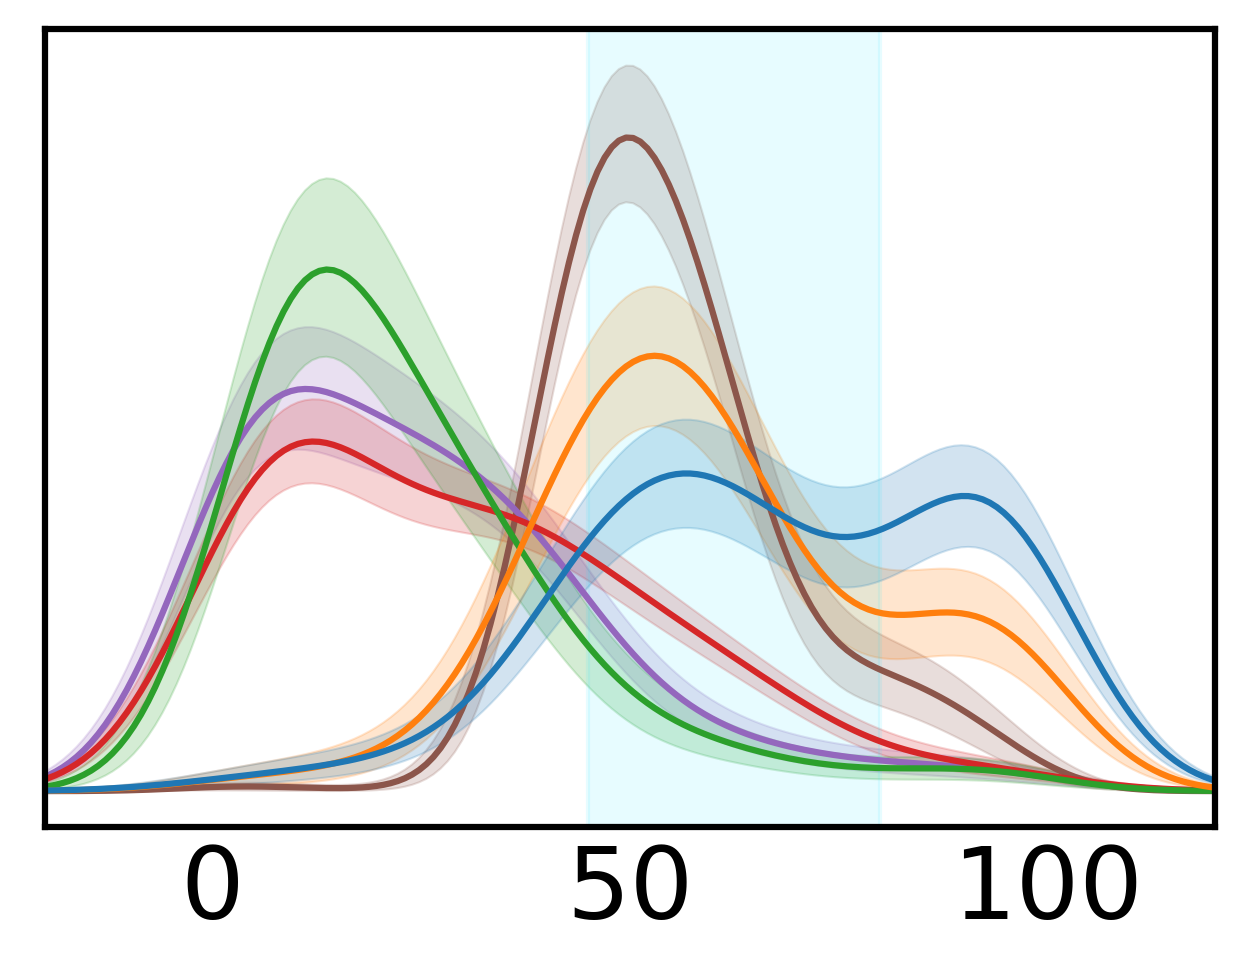

In [32]:
ax = polarity(temp_df, gene_dict, region_key="rc_coord",
              palette=palette,
              itv_rpt=1,
              region_lower_bound=45,
              region_upper_bound=80,
             )

ax.tick_params(direction="out")
ax.set_yticks([])
# Remove the tick marks but keep the labels for the x-axis
ax.tick_params(axis='x', length=0, labelsize=24)

plt.xlim([-20, 120])
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

In [ ]:
# Replace path with appropriate local path for you
plt.savefig("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/KDE_expression_Lhx.pdf", bbox_inches = "tight", transparent=True, width=2, height=1)

### For figure 6e-g: target genes for modeling

In [33]:
# Reload AnnData object (in case): 
e115_zli = anndata.read_h5ad(path_to_zli)
e115_zli.uns["__type"] = "UMI"

#### Ligands and receptors

In [34]:
# Change path to the local path that stores Spateo's database
lr_db_path = "/home/danielyumengzhu/spateo-release/spateo/tools/database"
lr_db = pd.read_csv(os.path.join(lr_db_path, "lr_db_mouse.csv"), index_col=0)

In [ ]:
# Extract unique values from 'from' and 'to' columns
unique_l = lr_db['from'].unique().tolist()
unique_r = lr_db['to'].unique().tolist()

# Combine and remove duplicates
combined = set(unique_l + unique_r)

# Split elements containing '_'
split_elements = [item.split('_') for item in combined if '_' in item]
flat_list = [item for sublist in split_elements for item in sublist]

# Add split elements to combined set
combined.update(flat_list)

# Remove the elements containing '_' as they are already split
combined = {x for x in combined if '_' not in x}
print(len(combined))

unique_l = [item.split('_') for item in unique_l]
unique_l = set([item for sublist in unique_l for item in sublist])
print(len(unique_l))
unique_r = [item.split('_') for item in unique_r]
unique_r = set([item for sublist in unique_r for item in sublist])
print(len(unique_r))

In [ ]:
combined_sub = [g for g in combined if g in e115_zli.var_names]
print(len(combined_sub))

unique_l = [g for g in unique_l if g in e115_zli.var_names]
print(len(unique_l))

unique_r = [g for g in unique_r if g in e115_zli.var_names]
print(len(unique_r))

In [ ]:
df_expression = pd.DataFrame(e115_zli[:, combined_sub].X.toarray(), index=e115_zli.obs_names, columns=combined_sub)

In [ ]:
# Save ligands and receptors expressed in over n cells:
n = 2000
gene_counts = (df_expression > 0).sum()

# Filter ligands and receptors
expressed_ligands = gene_counts[unique_l][gene_counts > n].index.tolist()
expressed_receptors = gene_counts[unique_r][gene_counts > n].index.tolist()

len(expressed_ligands), len(expressed_receptors)

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_ligands.txt", "w") as file:
    for item in expressed_ligands:
        file.write("%s\n" % item)

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_receptors.txt", "w") as file:
    for item in expressed_receptors:
        file.write("%s\n" % item)

#### Target genes

In [ ]:
target_genes = [
    "Amot", "Arl4a", "Axin2", "Cdh8", "Celf4", "Chl1", "Cited2", "Clic6", "Colec12", "Cntn5",
    "Dcx", "Dlx2", "Eda", "Edil3", "Egfem1", "Eml5", "Ezr", "Ext1", "Flrt2", "Foxd1",
    "Gap43", "Gng3", "Igfbp5", "Id1", "Id4", "Ina", "Kcnip4", "Kcnq3", "Lrrc4c", "Magi1",
    "Mapk1", "Mdga2", "Meg3", "Mllt11", "Mycn", "Nkd1", "Nlgn1", "Nrxn3", "Ntn1", "Otx1",
    "Otx2os1", "Pcdh9", "Peg10", "Pdia6", "Plcl1", "Pten", "Ptk2", "Ptprn2", "Ptch1",
    "Rspo3", "Rtn1", "Sema5b", "Sfrp2", "Sgms1", "Slc1a2", "Slc22a23", "Slc6a15", "Spon1",
    "Stmn2", "Sulf1", "Sulf2", "Tead1", "Tenm4", "Th", "Thsd7a", "Tle1", "Trpm3", "Tmem132c",
    "Ybx1", "Zcchc18", "Zfp804b"
]

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_targets.txt", "w") as file:
    for item in target_genes:
        file.write("%s\n" % item)

In [35]:
# Set to the folders to save the inputs (ligands list, receptors list, targets list) and outputs (model results) to:
cci_input_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs"
cci_output_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/key_zli_genes"
cci_output_id = os.path.join(cci_output_directory, "key_zli_genes.csv")

#### Initialize CCI model

In [ ]:
e115_zli_lb = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_zli,
    coords_key="z_correction",
    n_anchors=2000,
    target_n_neighbors=27,
    initial_bw=20,
    exclude_self=True
)
e115_zli_lb

In [ ]:
e115_zli_ub = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_zli,
    coords_key="z_correction",
    n_anchors=2000,
    target_n_neighbors=250,
    initial_bw=20,
    exclude_self=True
)
e115_zli_ub

In [ ]:
# Change all paths in below block to the appropriate locations on your local machine

In [36]:
adata_path = path_to_zli
output_path = cci_output_id
# Use the ligand/receptor paths from the model fitting:
ligand_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_ligands.txt"
# Note that even though receptor path is given, this is not actually used for figure 6, which uses only the ligands because the data is very sparse- but if "mod_type" is "lr", this will be used.
receptor_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_receptors.txt"  
target_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_targets.txt"
cci_dir_path = lr_db_path
mod_type = "ligand"
species = "mouse"
distr = "poisson"
group_key = "mapped_celltype"
coords_key = "z_correction"
distance_membrane_bound = 6.6
distance_secreted = 16.5
total_counts_key = "total_counts"
total_counts_threshold = 2000.0
# Effective radius for each cell that assumes cell size = 10um, diameter signaling range = 250um, and cells are not tightly packed, w/ a (erring on the larger side)
# distance of 30um between neighbors
minbw = 10.0
maxbw = 23.0
spatial_subsample = True

In [37]:
parser, args_list = st.tl.define_spateo_argparse(
    adata_path=adata_path,
    custom_lig_path=ligand_path,
    custom_rec_path=receptor_path,
    targets_path=target_path,
    cci_dir=cci_dir_path,
    mod_type=mod_type,
    species=species,
    distr=distr,
    group_key=group_key,
    coords_key=coords_key,
    distance_membrane_bound=distance_membrane_bound,
    distance_secreted=distance_secreted,
    minbw=minbw,
    maxbw=maxbw,
    spatial_subsample=spatial_subsample,
    total_counts_key=total_counts_key,
    total_counts_threshold=total_counts_threshold,
    output_path=output_path,
)

In [ ]:
model = st.tl.MuSIC(parser, args_list)
model._set_up_model()
model.fit()
model.predict_and_save(adjust_for_subsampling=True)

#### Downstream model initialization

In [38]:
downstream_model = st.tl.MuSIC_Interpreter(parser, args_list)

------------------------------------------------------------
|-----> Spatial kernel: Adaptive Bisquare
|-----> Loading AnnData object from: /home/danielyumengzhu/Single-cell-data/cellbin_mouse_embryo_aligned_E11.5/E11.5_ZLI_final.h5ad
|-----> Model type: ligand
|-----> Loading cell-cell interaction databases from the following folder:  /home/danielyumengzhu/spateo-release/spateo/tools/database.
|-----> Using list of custom ligands from: /home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_ligands.txt.
|-----> Using list of custom receptors from: /home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_receptors.txt.
|-----> Using list of target genes from: /home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_CCI_analysis_inputs/zli_targets.txt.
|-----> Saving all outputs to this directory: /home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/key_zli_genes.
|--

##### Figure 6e (polarity plots for predicted CCI effects)

In [39]:
def polarity(
    test_df,
    column_dict: dict,
    region_key: str,
    palette: list,
    mode: str = "density",
    itv_rpt: int = 1,
    width: int = 5,
    height: int = 3.5,
    region_lower_bound=None,  # Optional parameters for region bounds
    region_upper_bound=None,
):
    """Visualize data variation along regions using columns from a DataFrame.

    Args:
        test_df (DataFrame): Data to be visualized.
        column_dict (dict): Specifies columns to be visualized, potentially grouped by annotations.
        region_key (str): Column name in test_df indicating regions.
        mode (str, optional): Visualization mode ('density' or 'exp'). Defaults to "density".
        region_lower_bound (int, optional): Lower bound of the region to highlight.
        region_upper_bound (int, optional): Upper bound of the region to highlight.
    """
    import scipy.stats as stat
    digi_region = np.array([])
    column_list = np.array([])
    column_mean = np.array([])
    column_mean_low = np.array([])
    column_mean_high = np.array([])

    if mode == "exp":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    column_mean_tmp = df_tmp[column].to_numpy()
                    digi_region = np.append(digi_region, np.repeat(i, len(df_tmp)))
                    column_list = np.append(column_list, np.repeat(column + " " + anno, len(df_tmp)))
                    column_mean = np.append(column_mean, column_mean_tmp)
        df_plt = pd.DataFrame({region_key: digi_region, "Column": column_list, "Mean value": column_mean})
        ax = sns.relplot(data=df_plt, x=region_key, y="Mean value", hue="Column")
    elif mode == "density":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    digi_region = np.append(digi_region, i)
                    column_list = np.append(column_list, column + " " + anno)
                    column_mean = np.append(column_mean, np.mean(df_tmp[column]))
                    data = df_tmp[column].to_numpy()
                    data = np.repeat(data, itv_rpt)
                    l, h = stat.t.interval(alpha=0.7, df=len(data)-1, loc=np.mean(data), scale=stat.sem(data))
                    if np.isnan(l):
                        l = np.mean(data)
                    if np.isnan(h):
                        h = np.mean(data)
                    column_mean_low = np.append(column_mean_low, max(0, l))
                    column_mean_high = np.append(column_mean_high, h)
        column_mean_low = column_mean_low + 1e-10
        column_mean_high = column_mean_high + 1e-10
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean})
        df_plt['Avg. effect'] = df_plt['Avg. effect'].clip(lower=0)
        plt.figure()
        p1 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p1.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_low})
        plt.figure()
        p2 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p2.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_high})
        plt.figure()
        p3 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p3.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        fig, ax = plt.subplots()
        fig.set_size_inches((width, height))
        uq_cl = np.unique(column_list)
        for k in range(len(uq_cl)):
            ax.plot(p1.get_children()[k].get_data()[0], p1.get_children()[k].get_data()[1], '-', color=palette[len(palette)-k-1])
            ax.fill_between(
                p1.get_children()[k].get_data()[0],
                p2.get_children()[k].get_data()[1]*np.sum(column_mean_low[column_list==uq_cl[-(k+1)]]) / np.sum(column_mean[column_list==uq_cl[-(k+1)]]),
                p3.get_children()[k].get_data()[1]*np.sum(column_mean_high[column_list==uq_cl[-(k+1)]])/ np.sum(column_mean[column_list==uq_cl[-(k+1)]]), color=palette[len(palette)-k-1], alpha=0.2)

        if region_lower_bound is not None and region_upper_bound is not None:
            plot_width = region_upper_bound - region_lower_bound
            region_box = mpl.patches.Rectangle(
                (region_lower_bound, ax.get_ylim()[0]),
                plot_width,
                ax.get_ylim()[1] - ax.get_ylim()[0],
                linewidth=1,
                edgecolor="#1CE6FF",
                facecolor="#1CE6FF",
                alpha=0.1,
            )
            ax.add_patch(region_box)
    return ax

In [40]:
pairs = ["Vegfa-Dcx", "Agrn-Th", "Slit2-Ina", "Bmp6-Ext1", "Bmp7-Id1", "Ptn-Gap43", "Agrn-Stmn2", "Bmp7-Eml5"]

In [41]:
temp_df = pd.DataFrame(0, index=e115_zli.obs_names, columns=pairs) 

for pair in pairs:
    file_path = f"{cci_output_id[:-4]}_{pair.split('-')[1]}.csv"
    coeffs_df = pd.read_csv(file_path, index_col=0)
    temp_df[pair] = coeffs_df[f"b_{pair.split('-')[0]}"]

In [42]:
ax = e115_zli.obsm["z_correction"][:, 0]
ax = (ax - ax.min()) / (ax.max() - ax.min()) * 100
ax = ax.astype(int)
temp_df["rc_coord"] = ax

In [ ]:
# Guide: 
# Vegfa-Dcx = blue
# Ptn-Gap43 = orange
# Agrn-Th = green
# Slit2-Ina = red
# Bmp6-Ext1 = purple
# Agrn-Stmn2 = brown
# Bmp7-Eml5 = pink
# Bmp7-Id1 = grey

column_dict = {
    "1": ["Vegfa-Dcx"],
    "2": ["Ptn-Gap43"],
    "3": ["Agrn-Th"],
    "4": ["Slit2-Ina"],
    "5": ["Bmp6-Ext1"],
    "6": ["Agrn-Stmn2"],
    "7": ["Bmp7-Eml5"],
    "8": ["Bmp7-Id1"],
}

In [44]:
import matplotlib as mpl
palette = [mpl.colors.to_hex(i) for i in sns.color_palette("tab10" ,n_colors=len(column_dict))]
palette

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f']

/tmp/ipykernel_1439/3498202625.py:51: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide



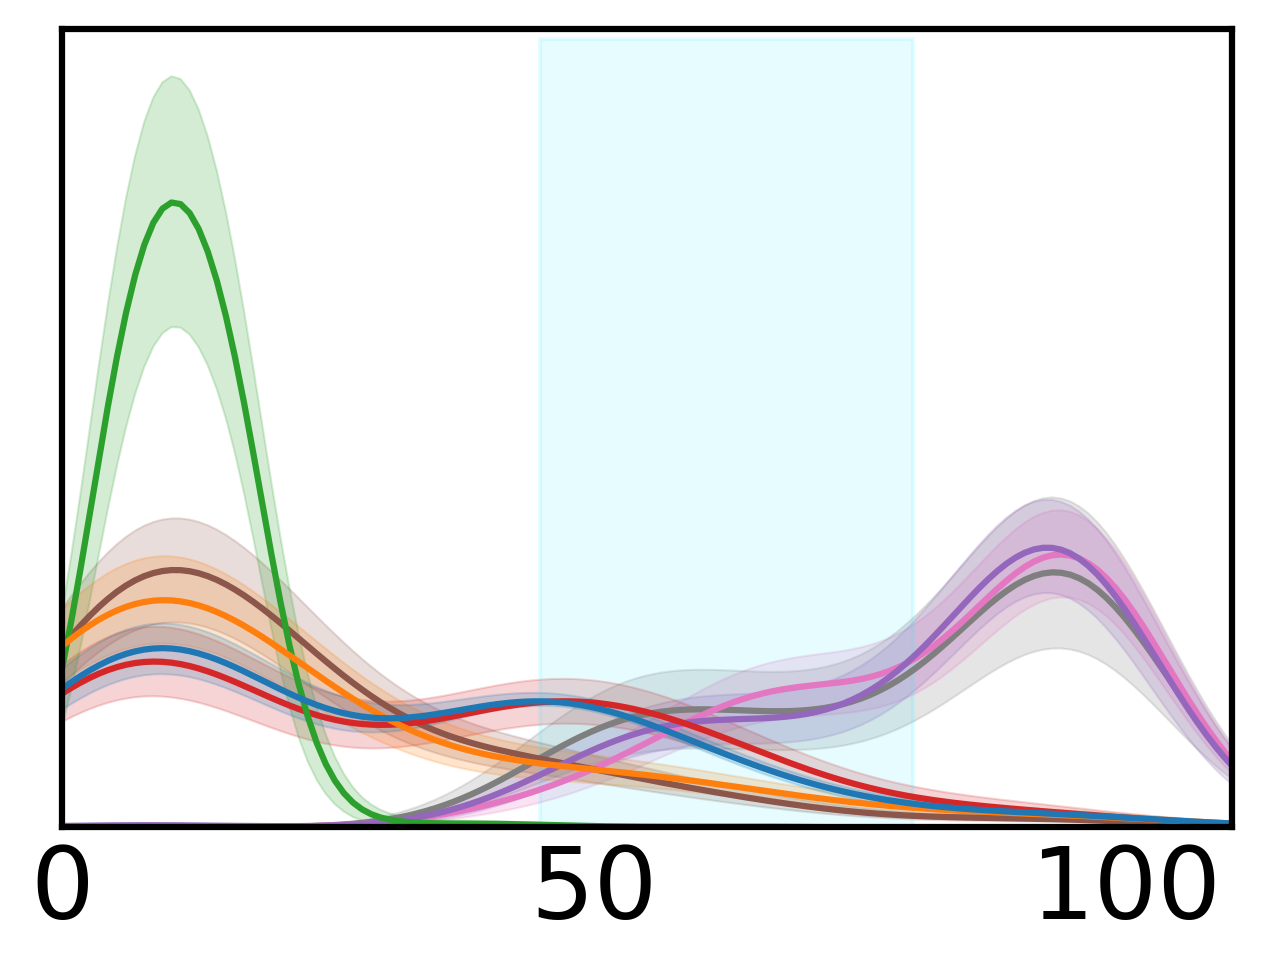

In [45]:
ax = polarity(temp_df, column_dict, region_key="rc_coord",
              palette=palette,
              itv_rpt=1,
              region_lower_bound=45,
              region_upper_bound=80,
             )
ax.tick_params(direction="out")
ax.set_yticks([])
ax.tick_params(axis='x', length=0, labelsize=24)
plt.xlim([0, 110])
plt.ylim([0.00, 0.075])

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

In [ ]:
# Replace path with appropriate local path for you
plt.savefig("/mnt/d/SCAnalysis/Spateo_E11.5_embryo_ZLI/KDE_CCI_effects.pdf", bbox_inches = "tight", transparent=True, width=2, height=1)

##### Run downstream TF-target model for figure 6f insights

In [ ]:
# Comments: can toggle "use_targets" and "use_ligands" between True and False for TF-target model where targets are downstream target genes of the CCI model and 
# ligands of the CCI model, respectively. Only one should be True at one time. For convenience, here the blocks are repeated with the appropriate adjustment.

In [ ]:
downstream_model.CCI_deg_detection_setup(
    group_key="mapped_celltype",
    use_ligands=False,
    use_receptors=False,
    use_targets=True
)

In [ ]:
downstream_model.CCI_deg_detection(
    group_key="mapped_celltype",
    cci_dir_path=cci_dir_path,
    use_ligands=False,
    use_receptors=False,
    use_targets=True,
    use_dim_reduction=False,
    distr="poisson"
)

In [ ]:
downstream_model.CCI_deg_detection_setup(
    group_key="mapped_celltype",
    use_ligands=True,
    use_receptors=False,
    use_targets=False
)

In [ ]:
downstream_model.CCI_deg_detection(
    group_key="mapped_celltype",
    cci_dir_path=cci_dir_path,
    use_ligands=True,
    use_receptors=False,
    use_targets=False,
    use_dim_reduction=False,
    distr="poisson"
)

##### Visualize predicted effect of ligand on target

In [ ]:
# Change the save path to appropriate local path:
save_path = f"/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_{affected_gene}_{ligand}_effect.html"

In [ ]:
affected_gene = "Id1"
ligand = "Bmp6"

In [ ]:
downstream_model.plot_interaction_effect_3D(
    target=affected_gene,
    interaction=ligand,
    save_path=save_path,
    pcutoff=99.9,
    size=3.5,
)

##### Visualize predicted effect of TF on ligand, target, etc.

In [ ]:
affected_gene = "Id1"
tf = "Smad4"

In [ ]:
# Change the save path to appropriate local path:
save_path = f"/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_{affected_gene}_{tf}_effect.html"

In [ ]:
downstream_model.plot_tf_effect_3D(
    target=affected_gene,
    tf=tf,
    save_path=save_path,
    ligand_targets=True,
    target_gene_targets=False,
    size=3.5
)

##### Summarize interaction effects (resource used for figure 6g network construction)

In [ ]:
interaction_effects_df = downstream_model.summarize_interaction_effects()
interaction_effects_df

In [ ]:
# Change to appropriate path
save_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/ZLI_interaction_effect_summary.csv"

In [ ]:
interaction_effects_df.to_csv(save_path)

In [ ]:
interaction_effects_df = pd.read_csv(save_path, index_col=0)

In [ ]:
# Top n ligands for each target gene
n = 10
threshold = 0.0

In [ ]:
# Optional: remove particular rows that are very common- also some of the things that are not intercellular ligands:
remove = ["Agrn", "Cdh2", "Ptn", "Igf2", "Mdk", "Mif", "Lipa"]

In [ ]:
if "remove" in locals():
    main_targets_interaction_effects_summary = main_targets_interaction_effects_summary.loc[[i for i in main_targets_interaction_effects_summary.index if i not in remove], :]

In [ ]:
# Get the most enriched effectors (ligands) for each target
main_targets_interaction_effects_summary = (main_targets_interaction_effects_summary - main_targets_interaction_effects_summary.min()) / (main_targets_interaction_effects_summary.max() - main_targets_interaction_effects_summary.min())

In [ ]:
top_n_columns_per_row = main_targets_interaction_effects_summary.apply(lambda row: row[row > threshold].nlargest(n).index.tolist(), axis=1)

# This was used to identify, e.g. target genes specific to a particular ligand/ligand family
for i, top_columns in enumerate(top_n_columns_per_row):
    print(f"Row {top_n_columns_per_row.index[i]}: Top columns: {top_columns}")

In [ ]:
# Note that the network is not comprehensive or constructed based on quantitative metrics/rankings- in reality these networks will likely span thousands of genes & dozens of signals.
# We identified genes enriched in particular regions of the brain, with previously reported biological function in development (e.g. Id1, etc.) and identified ligands appearing to have high 
# specificity for those genes based on the ranking above

### Figure 6b (CCI model result for the diencephalic ring)

#### Ligands and receptors

In [ ]:
# Change path to the local path that stores Spateo's database
lr_db_path = "/home/danielyumengzhu/spateo-release/spateo/tools/database"
lr_db = pd.read_csv(os.path.join(lr_db_path, "lr_db_mouse.csv"), index_col=0)

In [ ]:
# Extract unique values from 'from' and 'to' columns
unique_l = lr_db['from'].unique().tolist()
unique_r = lr_db['to'].unique().tolist()

# Combine and remove duplicates
combined = set(unique_l + unique_r)

# Split elements containing '_'
split_elements = [item.split('_') for item in combined if '_' in item]
flat_list = [item for sublist in split_elements for item in sublist]

# Add split elements to combined set
combined.update(flat_list)

# Remove the elements containing '_' as they are already split
combined = {x for x in combined if '_' not in x}
print(len(combined))

unique_l = [item.split('_') for item in unique_l]
unique_l = set([item for sublist in unique_l for item in sublist])
print(len(unique_l))
unique_r = [item.split('_') for item in unique_r]
unique_r = set([item for sublist in unique_r for item in sublist])
print(len(unique_r))

In [ ]:
combined_sub = [g for g in combined if g in e115_dien_ring.var_names]
print(len(combined_sub))

unique_l = [g for g in unique_l if g in e115_dien_ring.var_names]
print(len(unique_l))

unique_r = [g for g in unique_r if g in e115_dien_ring.var_names]
print(len(unique_r))

In [ ]:
df_expression = pd.DataFrame(e115_dien_ring[;, combined].X.toarray(), index=e115_dien_ring.obs_names, columns=combined)

In [ ]:
# Save ligands and receptors expressed in over n cells:
n = int(0.05 * e115_dien_ring.n_obs)
gene_counts = (df_expression > 0).sum()

# Filter ligands and receptors
expressed_ligands = gene_counts[unique_l][gene_counts > n].index.tolist()
expressed_receptors = gene_counts[unique_r][gene_counts > n].index.tolist()

len(expressed_ligands), len(expressed_receptors)

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_ligands.txt", "w") as file:
    for item in expressed_ligands:
        file.write("%s\n" % item)

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_receptors.txt", "w") as file:
    for item in expressed_receptors:
        file.write("%s\n" % item)

#### Target genes

In [ ]:
target_genes = [
    "Calm1", "Cdkn1c", "Cenpw", "Ckb", "Clybl", "Cpe", "Dusp6", "Elavl4", "Emb", "Ext1", 
    "Ezr", "Gja1", "Gli3", "Glis3", "Hes5", "Id3", "Igdcc3", "Igfbp2", "Itm2c", 
    "Map1b", "Map2", "Mecom", "Mest", "Miat", "Mllt3", "Nes", "Neurog2", "Nfia", "Nrarp", 
    "Nxn", "Ppp1r1a", "Ptprd", "Rgma", "Rmst", "Rspo1", "Serpinh1", "Sox11", "Sox9", "Spry1", 
    "Stmn1", "Sufu", "Tle4", "Tmeff1", "Tmsb4x", "Tpm1", "Tuba1a", "Tubb2b", "Tubb3", "Zfp503", 
    "Zic1", "Zic3", "Zic4", "Zic5"
]

In [ ]:
with open("/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_targets.txt", "w") as file:
    for item in target_genes:
        file.write("%s\n" % item)

#### Initialize CCI model

In [ ]:
cci_lower_bound = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_dien_ring,
    coords_key="z_correction",
    n_anchors=2000,
    target_n_neighbors=27,
    initial_bw=200,
    exclude_self=True
)
cci_lower_bound

In [ ]:
cci_upper_bound = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_dien_ring,
    coords_key="spatial",
    n_anchors=2000,
    target_n_neighbors=250,
    initial_bw=200,
    exclude_self=True
)
cci_upper_bound

In [ ]:
# Change all paths in below blocks to the appropriate locations on your local machine

In [ ]:
# Set to the folders to save the inputs (ligands list, receptors list, targets list) and outputs (model results) to:
cci_input_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs"
cci_output_directory = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/key_dien_ring_genes"
cci_output_id = os.path.join(cci_output_directory, "key_dien_ring_genes.csv")

In [ ]:
adata_path = path_to_dien_ring
output_path = cci_output_id
# Use the ligand/receptor paths from the model fitting:
ligand_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_ligands.txt"
# Note that even though receptor path is given, this is not actually used for figure 6, which uses only the ligands because the data is very sparse- but if "mod_type" is "lr", this will be used.
receptor_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_receptors.txt"  
target_path = "/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/dien_ring_CCI_analysis_inputs/diencephalic_ring_targets.txt"
cci_dir_path = lr_db_path
mod_type = "ligand"
species = "mouse"
distr = "poisson"
group_key = "mapped_celltype"
coords_key = "z_correction"
distance_membrane_bound = 6.37
n_neighbors_membrane_bound = 27
distance_secreted = 16.17
# Effective radius for each cell that assumes cell size = 10um, diameter signaling range = 250um, and cells are not tightly packed, w/ a (erring on the larger side)
# distance of 30um between neighbors
n_neighbors_secreted = 250
minbw = 9.55
maxbw = 24.25
spatial_subsample = True

In [ ]:
parser, args_list = st.tl.define_spateo_argparse(
    adata_path=adata_path,
    custom_lig_path=ligand_path,
    custom_rec_path=receptor_path,
    targets_path=target_path,
    cci_dir=cci_dir_path,
    mod_type=mod_type,
    species=species,
    distr=distr,
    group_key=group_key,
    coords_key=coords_key,
    distance_membrane_bound=distance_membrane_bound,
    n_neighbors_membrane_bound=n_neighbors_membrane_bound,
    distance_secreted=distance_secreted,
    n_neighbors_secreted=n_neighbors_secreted,
    minbw=minbw,
    maxbw=maxbw,
    spatial_subsample=spatial_subsample,
    output_path=output_path,
)

In [ ]:
downstream_model = st.tl.MuSIC_Interpreter(parser, args_list)

In [ ]:
# Fgf8 effect on Sufu
target = "Sufu"
ligand = "Fgf8"

In [ ]:
save_path = f"/home/danielyumengzhu/Single-cell-analysis/Spateo_E11.5_embryo_figures/diencephalic_ring_Fgf8_Sufu_effect.html"

In [ ]:
downstream_model.plot_interaction_effect_3D(
    target=target,
    interaction=interaction,
    size=3.5,
    save_path=save_path
)